In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

import base64
import firebase_admin
from firebase_admin import credentials, firestore

Global


In [6]:
# Initialize Firebase if it is not already initialized
if not firebase_admin._apps:
    cred = credentials.Certificate('credentials.json')
    firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()

# Retrieve all documents in the collection 'models'.
models_ref = db.collection('models')
docs = models_ref.stream()

# List to store the loaded models
models = []

# Iterating on Firestore documents
for doc in docs:
    # Get the base64 string of the document
    encoded_string = doc.to_dict().get('model')

    if encoded_string:
        # Decode the base64 string and save the file
        file_name = f"reconstructed_{doc.id}.sav"  # Use document ID to name the file
        with open(file_name, 'wb') as file:
            file.write(base64.b64decode(encoded_string))
        
        print(f"File {file_name} successfully rebuilt from Firestore")
        
        # Load the model using pickle
        try:
            model = pickle.load(open(file_name, 'rb'))
            models.append((f"model_{doc.id}", model))  # Save the model with the corresponding name
        except Exception as e:
            print(f"Error loading model {file_name}: {e}")
    else:
        print(f"Document {doc.id} does not contain the base64 model")

# Create a voting classifier with the loaded patterns
if len(models) > 0:
    ensemble_model = VotingClassifier(estimators=models, voting='hard')
    print("Voting model successfully created")

# Guardar el modelo
    with open('ensemble_model.pkl', 'wb') as f:
        pickle.dump(ensemble_model, f)

    ## Now you can use 'ensemble_model' to make predictions
    ## Example:
    # ensemble_model.fit(X_train, y_train) ## If you need to retrain it.
    # predictions = ensemble_model.predict(X_test)
    # print(predictions)
else:
    print("No models have been loaded to create the voting classifier.")


File reconstructed_dtree_mpu9050_1.sav successfully rebuilt from Firestore
File reconstructed_knn_mpu9050_1.sav successfully rebuilt from Firestore
File reconstructed_knn_mpu9050_2.sav successfully rebuilt from Firestore
Voting model successfully created


In [7]:
print(f"model_{doc.id}")

model_knn_mpu9050_2


In [8]:
ensemble_model

VotingClassifier(estimators=[('model_dtree_mpu9050_1',
                              DecisionTreeClassifier(random_state=0)),
                             ('model_knn_mpu9050_1',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('model_knn_mpu9050_2',
                              KNeighborsClassifier(n_neighbors=3))])

<Figure size 600x600 with 0 Axes>

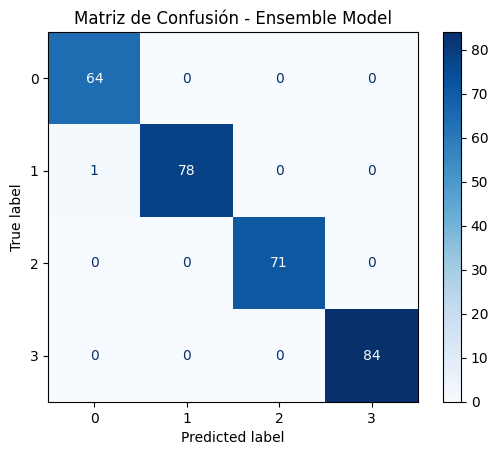

,precision,recall,f1-score,support
0,0.984615,1.000000,0.992248,64.000000
1,1.000000,0.987342,0.993631,79.000000
2,1.000000,1.000000,1.000000,71.000000
3,1.000000,1.000000,1.000000,84.000000
accuracy,0.996644,0.996644,0.996644,0.996644
macro avg,0.996154,0.996835,0.996470,298.000000
weighted avg,0.996696,0.996644,0.996647,298.000000


In [10]:
# Cargar el conjunto de datos
data_path = "Data_141124.csv"
df = pd.read_csv(data_path)

# Eliminar columnas innecesarias
df = df.drop(columns=['DateRecord', 'TimeRecord'], errors='ignore')

# Separar características y etiquetas
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Aplicar el escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

# Cargar el modelo ensemble_model
ensemble_model_path = "ensemble_model.pkl"
with open(ensemble_model_path, "rb") as f:
    ensemble_model = pickle.load(f)

# ENTRENAR el modelo si no está entrenado
ensemble_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_ensemble = ensemble_model.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Mostrar la matriz de confusión
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Ensemble Model")
plt.show()

# Generar el reporte de clasificación
metrics_df = pd.DataFrame.from_dict(
    classification_report(y_test, y_pred_ensemble, output_dict=True)
).transpose()

# Mostrar las métricas
display(metrics_df)